# Test `alignparse.ccs.Summaries`
Tests this class and makes sure it works with and without reports and `np` tags giving number of passes.
This Jupyter notebook is designed to be run with `nbval` for the testing.

First, import Python modules:

In [1]:
import contextlib
import os
import tempfile
import warnings

import Bio.SeqIO

import pandas as pd

import alignparse.ccs

Hide warnings that clutter output:

In [2]:
warnings.simplefilter('ignore')

Data frame giving the `ccs` report file and the CCS FASTQ file for each run:

In [3]:
run_names = ['recA_lib-1', 'recA_lib-2']
ccs_dir = '../notebooks/input_files'

ccs_df = pd.DataFrame(
            {'name': run_names,
             'report': [f"{ccs_dir}/{name}_report.txt" for name in run_names],
             'fastq': [f"{ccs_dir}/{name}_ccs.fastq" for name in run_names]
             })

Create an `alignparse.ccs.Summaries` object:

In [4]:
summaries = alignparse.ccs.Summaries(ccs_df)

for summary in summaries.summaries:
    print(summary.name)

recA_lib-1
recA_lib-2


Confirm ZMW stats exist:

In [5]:
summaries.has_zmw_stats()

True

Get and plot the ZMW stats:

In [6]:
summaries.zmw_stats()

,name,status,number,fraction
0,recA_lib-1,Success -- CCS generated,98,0.6125
1,recA_lib-1,Failed -- Not enough full passes,38,0.2375
2,recA_lib-1,Failed -- CCS below minimum predicted accuracy,23,0.1437
3,recA_lib-1,Failed -- Other reason,1,0.0063
4,recA_lib-2,Success -- CCS generated,100,0.6410
5,recA_lib-2,Failed -- Not enough full passes,36,0.2308
6,recA_lib-2,Failed -- CCS below minimum predicted accuracy,20,0.1282
7,recA_lib-2,Failed -- Other reason,0,0.0000


Plot these stats:

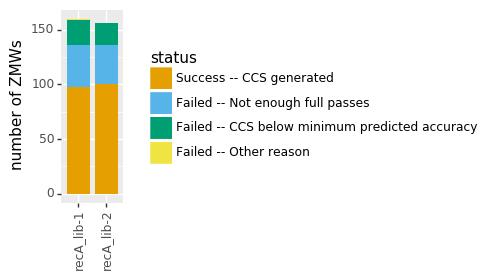

In [7]:
p = summaries.plot_zmw_stats()
_ = p.draw()

Now do the same with a `Summaries` object with no reports defined:

In [8]:
summaries_no_zmw = alignparse.ccs.Summaries(ccs_df, report_col=None, ncpus=1)

No ZMW stats defined:

In [9]:
summaries_no_zmw.has_zmw_stats()

False

So trying to get stats raises an error:

In [10]:
try:
    summaries_no_zmw.plot_zmw_stats()
except ValueError:
    print('cannot plot ZMW stats')

cannot plot ZMW stats


Now get information on CCS statistics:

In [11]:
for stat in ['passes', 'length', 'accuracy']:
    if summaries.has_stat(stat):
        print(summaries.ccs_stats(stat).head(n=5))
        print()
    else:
        print(f"no {stat} stat\n")

         name  passes
0  recA_lib-1      27
1  recA_lib-1     127
2  recA_lib-1      45
3  recA_lib-1      17
4  recA_lib-1      17

         name  length
0  recA_lib-1    1344
1  recA_lib-1    1342
2  recA_lib-1    1342
3  recA_lib-1    1344
4  recA_lib-1    1342

         name  accuracy
0  recA_lib-1  0.999664
1  recA_lib-1  1.000000
2  recA_lib-1  1.000000
3  recA_lib-1  0.999094
4  recA_lib-1  0.999450



Plot these stats:

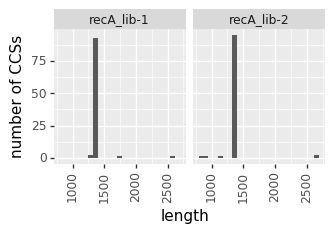

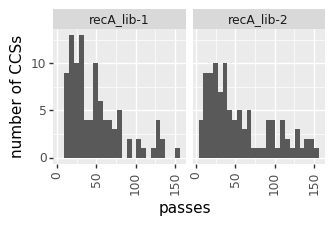

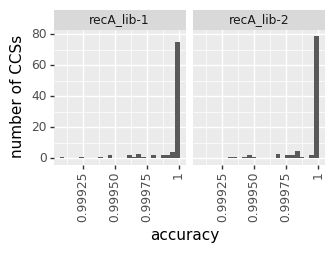

In [12]:
for stat in ['length', 'passes', 'accuracy']:
    try:
        p = summaries.plot_ccs_stats(stat)
        _ = p.draw()
    except ValueError:
        print(f"Cannot plot {stat}")

Now do the same for a `Summaries` defined using FASTQ files without the `np` tag giving the number of passes:

In [13]:
with contextlib.ExitStack() as stack:
    tempfiles = [stack.enter_context(tempfile.NamedTemporaryFile('wt', suffix='.fastq'))
                 for _ in range(len(ccs_df))]
    ccs_df = ccs_df.assign(fastq_nopasstag=[f.name for f in tempfiles])
    for fout, tup in zip(tempfiles, ccs_df.itertuples()):
        seqs = []
        for iseq, seq in enumerate(Bio.SeqIO.parse(tup.fastq, 'fastq')):
            if iseq == 0:  # drop np tag from just first
                seq.description = seq.description.split()[0]
            seqs.append(seq)
        Bio.SeqIO.write(seqs, fout, 'fastq')
        fout.flush()
    summaries_nopasstag = alignparse.ccs.Summaries(ccs_df, fastq_col='fastq_nopasstag')

Now print and plot information without `np` tag:

In [14]:
for stat in ['passes', 'length', 'accuracy']:
    if summaries_nopasstag.has_stat(stat):
        print(summaries_nopasstag.ccs_stats(stat).head(n=5))
        print()
    else:
        print(f"no {stat} stat\n")

no passes stat

         name  length
0  recA_lib-1    1344
1  recA_lib-1    1342
2  recA_lib-1    1342
3  recA_lib-1    1344
4  recA_lib-1    1342

         name  accuracy
0  recA_lib-1  0.999664
1  recA_lib-1  1.000000
2  recA_lib-1  1.000000
3  recA_lib-1  0.999094
4  recA_lib-1  0.999450



Cannot plot passes


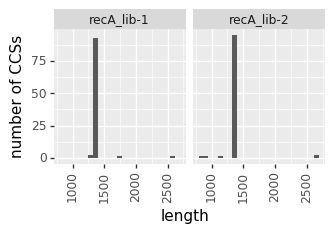

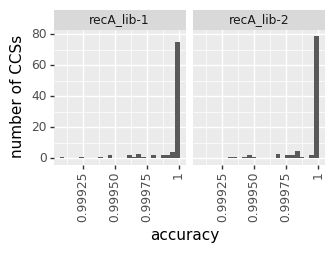

In [15]:
for stat in ['length', 'passes', 'accuracy']:
    try:
        p = summaries_nopasstag.plot_ccs_stats(stat)
        _ = p.draw()
    except ValueError:
        print(f"Cannot plot {stat}")